In [1]:
import pandas as pd
import numpy as np
import numpy.random as nr
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

%matplotlib inline

The code in the cell below loads a prepared version of the autos dataset which has the the following preprocessing:
1. Clean missing values.
2. Aggregate categories of certain categorical variables. 
3. Encode categorical variables as binary dummy variables.
4. Standardize of numeric variables. 

However, for this case, some additional processing is required:
1. The log of the Label vector is taken. You know from previous analysis that the log of the Label (price) values are closer to being linearly related to several of the numeric features. Further, the log of the Label is closer to Normally distributed. 
2. The Label value is Zscore standardized to ensure the variance is 1.0 and the mean 0.0. As with all machine learning, scaling is vital in cluster analysis to avoid bias in the solution. 
3. The vector of scaled log transformed Label values is appended to the features to create the complete dataset. 

In [2]:
Features = np.array(pd.read_csv('Auto_Data_Features.csv'))
Labels = np.array(pd.read_csv('Auto_Data_Labels.csv'))
Labels = np.log(Labels)
scaler = StandardScaler()
Labels = scaler.fit_transform(Labels)
Auto_Data = np.concatenate((Features,Labels), 1)
print(Auto_Data.shape)

(195, 46)


Notice that the dataset has 46 columns (dimensions) for a small number of cases, 195. The small number of rows compared to the number of features adds to the challenge of this problem. 

In order to create meaningful visualizations of the cluster assignments a version of the dataset in the original units. 

In [10]:
auto_prices = pd.read_csv('Automobile price data _Raw_.csv')
'''
for i in auto_prices.columns:
    print(auto_prices[i].unique())
'''

def clean_auto_data(auto_prices):
    'Function to load the auto price data set from a .csv file'     
    ## Remove rows with missing values, accounting for mising values coded as '?'
    cols = ['price', 'bore', 'stroke', 
          'horsepower', 'peak-rpm']
    for column in cols:
        auto_prices.loc[auto_prices[column] == '?', column] = np.nan
    auto_prices.dropna(axis = 0, inplace = True)

    ## Convert some columns to numeric values
    for column in cols:
        auto_prices[column] = pd.to_numeric(auto_prices[column])
    
    ## fix column names so the '-' character becomes '_'
    cols = auto_prices.columns
    auto_prices.columns = [str.replace('-', '_') for str in cols]
        
    return auto_prices
auto_prices = clean_auto_data(auto_prices)

print(auto_prices.columns)

[ 3  1  2  0 -1 -2]
['?' '164' '158' '192' '188' '121' '98' '81' '118' '148' '110' '145' '137'
 '101' '78' '106' '85' '107' '104' '113' '150' '129' '115' '93' '142'
 '161' '153' '125' '128' '122' '103' '168' '108' '194' '231' '119' '154'
 '74' '186' '83' '102' '89' '87' '77' '91' '134' '65' '197' '90' '94'
 '256' '95']
['alfa-romero' 'audi' 'bmw' 'chevrolet' 'dodge' 'honda' 'isuzu' 'jaguar'
 'mazda' 'mercedes-benz' 'mercury' 'mitsubishi' 'nissan' 'peugot'
 'plymouth' 'porsche' 'renault' 'saab' 'subaru' 'toyota' 'volkswagen'
 'volvo']
['gas' 'diesel']
['std' 'turbo']
['two' 'four' '?']
['convertible' 'hatchback' 'sedan' 'wagon' 'hardtop']
['rwd' 'fwd' '4wd']
['front' 'rear']
[ 88.6  94.5  99.8  99.4 105.8  99.5 101.2 103.5 110.   88.4  93.7 103.3
  95.9  86.6  96.5  94.3  96.  113.  102.   93.1  95.3  98.8 104.9 106.7
 115.6  96.6 120.9 112.  102.7  93.   96.3  95.1  97.2 100.4  91.3  99.2
 107.9 114.2 108.   89.5  98.4  96.1  99.1  93.3  97.   96.9  95.7 102.4
 102.9 104.5  97.3 104.3 

In [11]:
auto_prices['price'] = np.log(auto_prices['price'])

marker_dic = {('gas','std'):'o', ('gas','turbo'):'s', ('diesel','std'):'x', ('diesel','turbo'):'^'}
markers = [marker_dic[(x,y)] for x,y in zip(auto_prices['fuel_type'], auto_prices['aspiration'])]

### Apply K-means clustering

Create and evaluate a series of K-means clustering models applied to the automotive data set. 

1. A dictionary is defined for mapping cluster assignment numbers to colors for the assignment visualization.
2. A K=2 K-means cluster model is defined. 
3. The data is fit to the cluster model and assignments are computed. 
4. The assignments are mapped to a list of colors. 

In [14]:
## k = 2
nr.seed(2233)
col_dic = {0:'blue',1:'green',2:'orange',3:'gray',4:'magenta',5:'black'}
kmeans_2 = KMeans(n_clusters=2, random_state=0)
assignments_km2 = kmeans_2.fit_predict(Auto_Data)
assign_color_km2 = [col_dic[x] for x in assignments_km2]

With high dimensional data many views are possible. However, given limits of perception it is often best to select a few meaningful views. In this case 5 numeric columns and 2 categorical variables are displayed, for a total of 7 of 45 possible dimensions.  

1. Lists of numeric columns are displayed.
2. The outer loop iterates over the column paris, the indices of the 4 plot axes. 
3. The inner loop iterates over the x and y coordinates, the color and marker shape. The points are plotted inside this loop
4. The annotation for the plot are added.

The K=2 clustering model has divided the data between high price, low fuel efficiency, high weight and high horsepower autos and ones that have the opposite characteristics. While this clustering is interesting, it can hardly be considered surprising. 

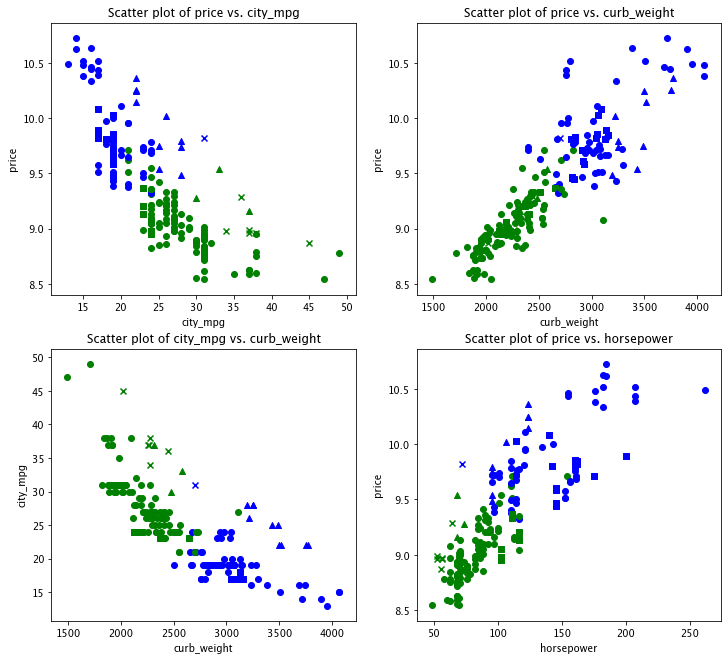

In [15]:
def plot_auto_cluster(auto_prices, assign_color, markers):
    fig, ax = plt.subplots(2, 2, figsize=(12,11)) # define plot area         
    x_cols = ['city_mpg', 'curb_weight', 'curb_weight', 'horsepower']
    y_cols = ['price', 'price', 'city_mpg', 'price']
    for x_col,y_col,i,j in zip(x_cols,y_cols,[0,0,1,1],[0,1,0,1]):
        for x,y,c,m in zip(auto_prices[x_col], auto_prices[y_col], assign_color, markers):
            ax[i,j].scatter(x,y, color = c, marker = m)
        ax[i,j].set_title('Scatter plot of ' + y_col + ' vs. ' + x_col) # Give the plot a main title
        ax[i,j].set_xlabel(x_col) # Set text for the x axis
        ax[i,j].set_ylabel(y_col)# Set text for y axis
    plt.show()

plot_auto_cluster(auto_prices, assign_color_km2, markers)

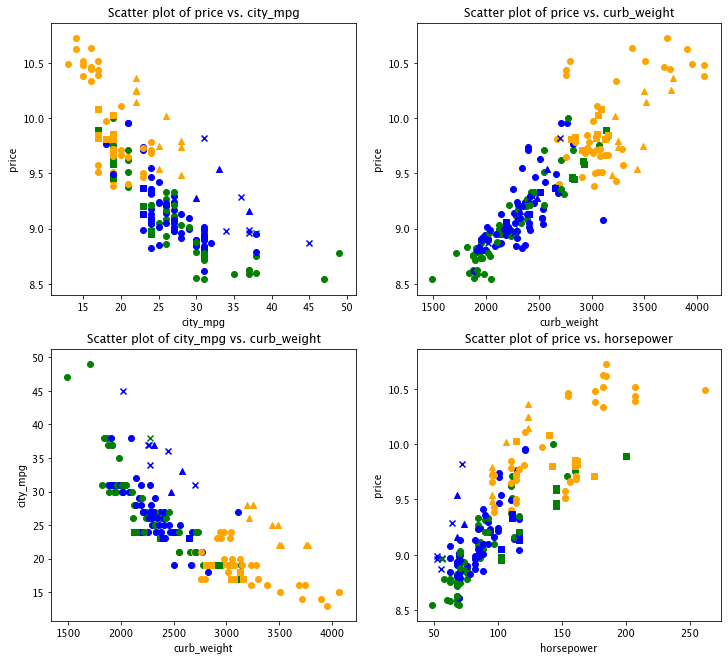

In [16]:
## k = 3
nr.seed(4455)
kmeans_3 = KMeans(n_clusters=3, random_state=0)
assignments_km3 = kmeans_3.fit_predict(Auto_Data)
assign_color_km3 = [col_dic[x] for x in assignments_km3]
plot_auto_cluster(auto_prices, assign_color_km3, markers)

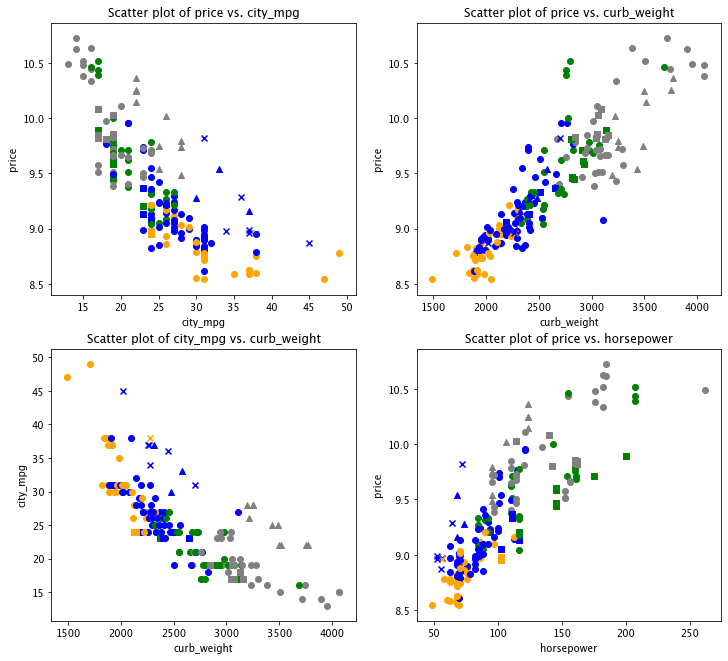

In [17]:
## k = 4
nr.seed(223)
kmeans_4 = KMeans(n_clusters=4, random_state=0)
assignments_km4 = kmeans_4.fit_predict(Auto_Data)
assign_color_km4 = [col_dic[x] for x in assignments_km4]
plot_auto_cluster(auto_prices, assign_color_km4, markers)

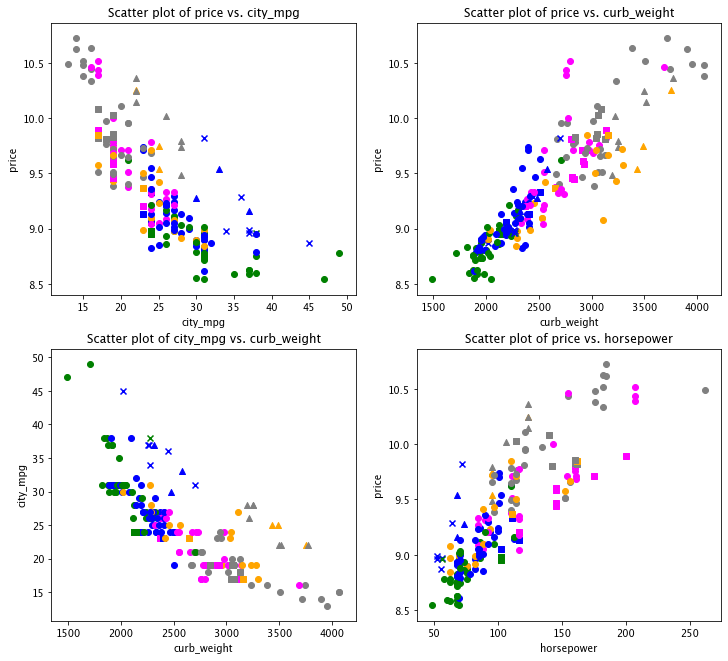

In [18]:
## k = 5
nr.seed(4443)
kmeans_5 = KMeans(n_clusters=5, random_state=0)
assignments_km5 = kmeans_5.fit_predict(Auto_Data)
assign_color_km5 = [col_dic[x] for x in assignments_km5]
plot_auto_cluster(auto_prices, assign_color_km5, markers)

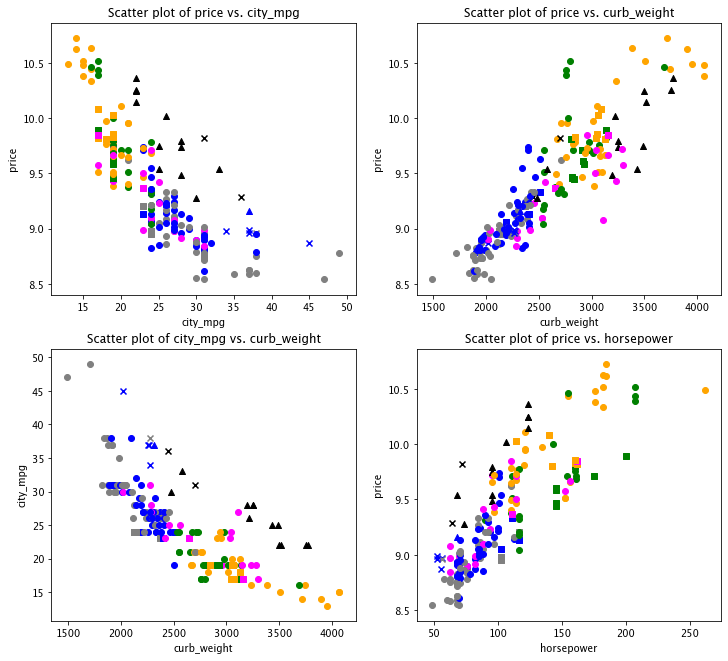

In [19]:
## k = 6
nr.seed(2288)
kmeans_6 = KMeans(n_clusters=6, random_state=0)
assignments_km6 = kmeans_6.fit_predict(Auto_Data)
assign_color_km6 = [col_dic[x] for x in assignments_km6]
plot_auto_cluster(auto_prices, assign_color_km6, markers)

The structure of these clusters follows the general pattern of the K=4 and K=5 models. The difference being that there is a finer grained divisions between the clusters.

While these visualizations are interesting, it is hard to select a best model based on just this evidence. To establish a quantitative basis for model selection, now compute and compare the within cluster sum of squares (WCSS), between cluster sum of squares (BCSS) and silhouette coefficient (SC) metrics.

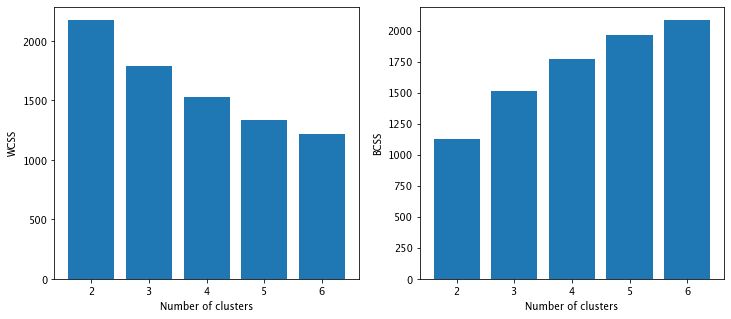

In [20]:
km_models = [kmeans_2, kmeans_3, kmeans_4, kmeans_5, kmeans_6]

def plot_WCSS_km(km_models, samples):
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    
    ## Plot WCSS
    wcss = [mod.inertia_ for mod in km_models]
    n_clusts = range(2,len(wcss) + 2)
    ax[0].bar(n_clusts, wcss)
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel('WCSS')
    
    ## Plot BCSS
    ## Compute BCSS as TSS - WCSS 
    n_1 = (float(samples.shape[0]) * float(samples.shape[1])) - 1.0
    tss = n_1 * np.var(samples)
    bcss = [tss - x for x in wcss]
    ax[1].bar(n_clusts, bcss)
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('BCSS')
    plt.show()
    

plot_WCSS_km(km_models, Auto_Data)
# The WCSS decreases with cluster number, rapidly at first. 
# The BCSS increases with cluster number, again rapidly at first. 
# These results indicate that higher numbers of clusters create models that are better at separating the clusters. 

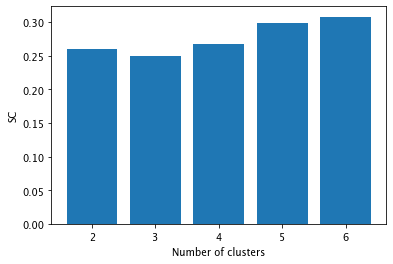

In [21]:
assignment_list = [assignments_km2, assignments_km3, assignments_km4, assignments_km5, assignments_km6]

def plot_sillohette(samples, assignments, x_lab = 'Number of clusters'):
    silhouette = [silhouette_score(samples, a) for a in assignments]
    n_clusts = range(2, len(silhouette) + 2)
    plt.bar(n_clusts, silhouette)
    plt.xlabel(x_lab)
    plt.ylabel('SC')
    plt.show()

plot_sillohette(Auto_Data, assignment_list)

# The SC is highest for the K=6 model, but only marginally higher than K=5. 
# The K=5 and K=6 models have significantly higher SC than for K=2, 3 or 4. 
# However, all these SC values are fairly low.
# Overall, it appears that the k=6 model is the best in terms of these metrics. 
# It also appears that there is an improvement over the K=5 model

### Apply agglomerative clustering

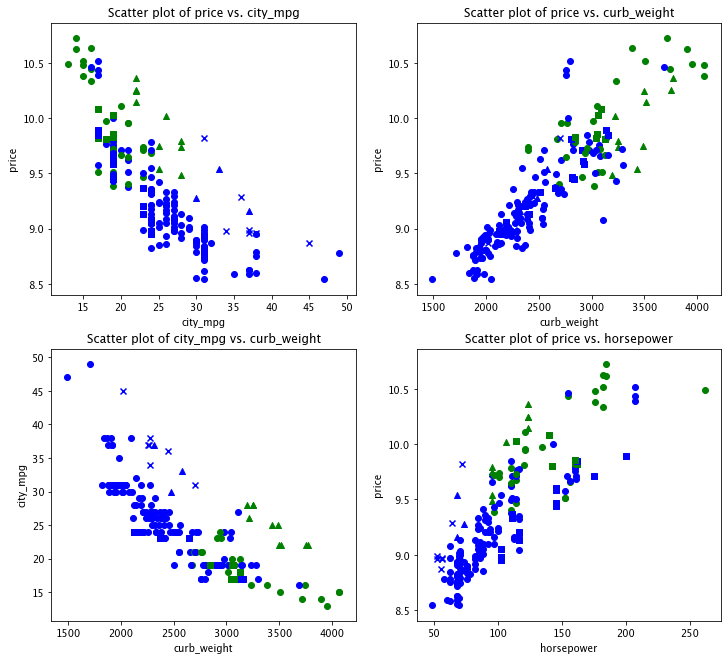

In [22]:
## clusters = 2
nr.seed(2233)
agc_2 = AgglomerativeClustering(n_clusters=2)
assignments_ag2 = agc_2.fit_predict(Auto_Data)
assign_color_ag2 = [col_dic[x] for x in assignments_ag2]
plot_auto_cluster(auto_prices, assign_color_ag2, markers)

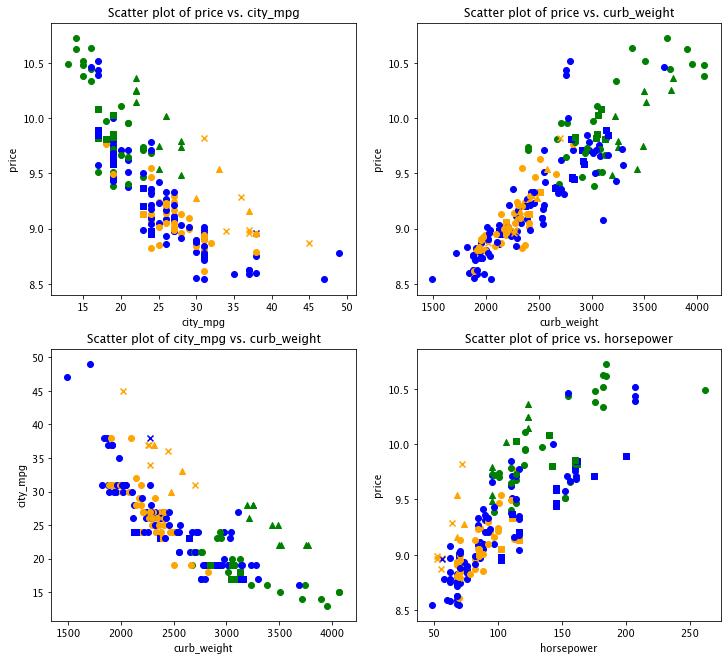

In [23]:
## clusters = 3
nr.seed(4433)
agc_3 = AgglomerativeClustering(n_clusters=3)
assignments_ag3 = agc_3.fit_predict(Auto_Data)
assign_color_ag3 = [col_dic[x] for x in assignments_ag3]
plot_auto_cluster(auto_prices, assign_color_ag3, markers)

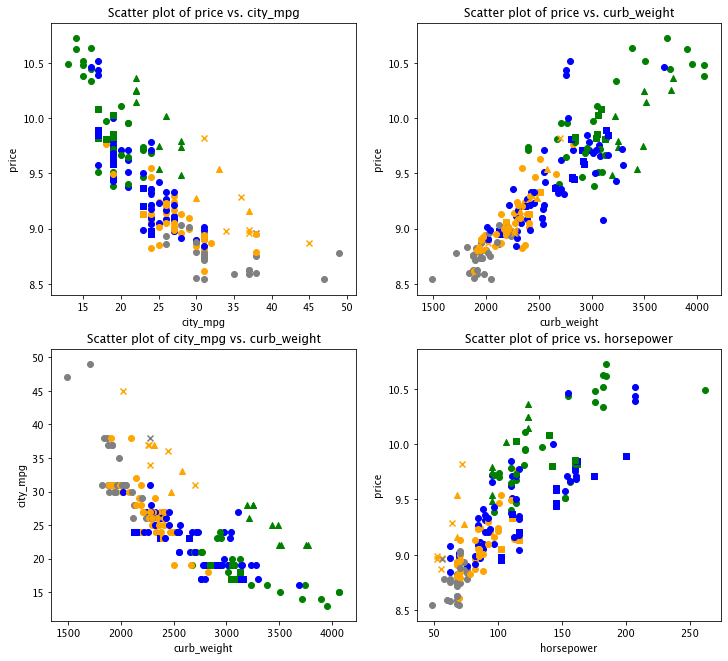

In [24]:
## clusters = 4
nr.seed(2663)
agc_4 = AgglomerativeClustering(n_clusters=4)
assignments_ag4 = agc_4.fit_predict(Auto_Data)
assign_color_ag4 = [col_dic[x] for x in assignments_ag4]
plot_auto_cluster(auto_prices, assign_color_ag4, markers)

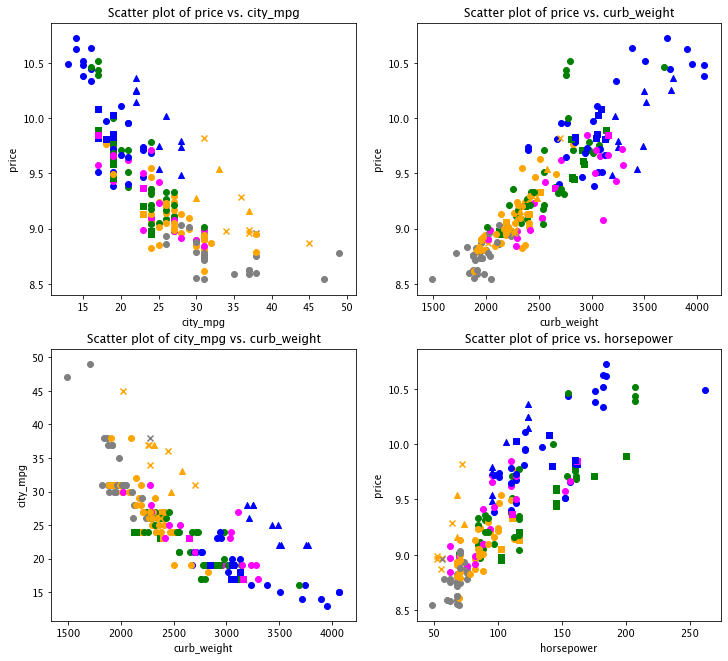

In [25]:
## clusters = 5
nr.seed(6233)
agc_5 = AgglomerativeClustering(n_clusters=5)
assignments_ag5 = agc_5.fit_predict(Auto_Data)
assign_color_ag5 = [col_dic[x] for x in assignments_ag5]
plot_auto_cluster(auto_prices, assign_color_ag5, markers)

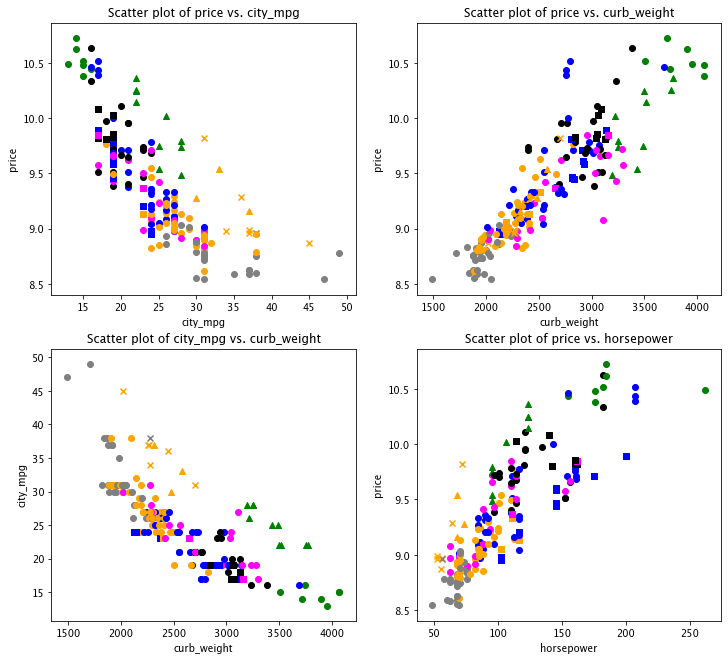

In [26]:
## clusters = 6
nr.seed(2288)
agc_6 = AgglomerativeClustering(n_clusters=6)
assignments_ag6 = agc_6.fit_predict(Auto_Data)
assign_color_ag6 = [col_dic[x] for x in assignments_ag6]
plot_auto_cluster(auto_prices, assign_color_ag6, markers)

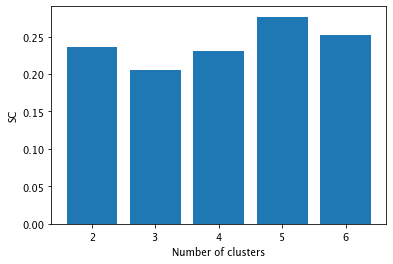

In [27]:
assignment_list = [assignments_ag2, assignments_ag3, assignments_ag4, assignments_ag5, assignments_ag6]
plot_sillohette(Auto_Data, assignment_list)